In [14]:
import numpy as np
import skimage
import matplotlib.pyplot as plt

# Loading the "cameraman" image
x = skimage.data.camera()
m, n = x.shape

# Printing its shape
print(f"Shape of the image: {x.shape}.")
# Compute the SVD decomposition of the image
U, s, Vt = np.linalg.svd(x, full_matrices=True)
print(f"The shape of U is {U.shape}, the shape of s is {s.shape} and the shape of Vt is {Vt.shape}")

# Define the full matrix S
S = np.zeros((m, n))
S[:n, :n] = np.diag(s)


Shape of the image: (512, 512).
The shape of U is (512, 512), the shape of s is (512,) and the shape of Vt is (512, 512)


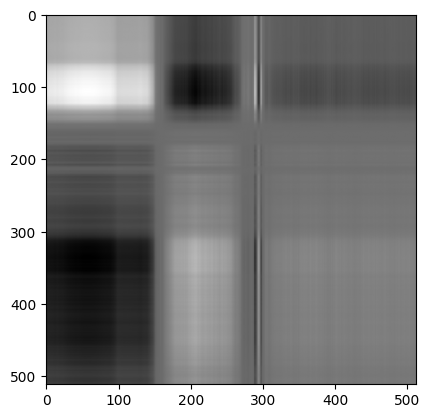

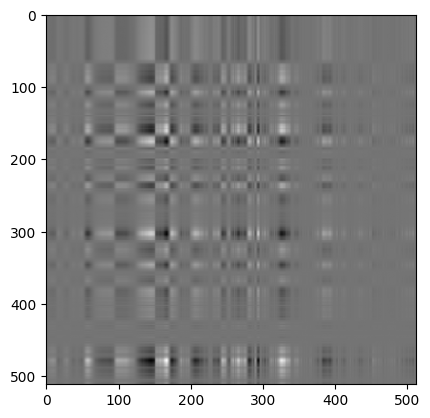

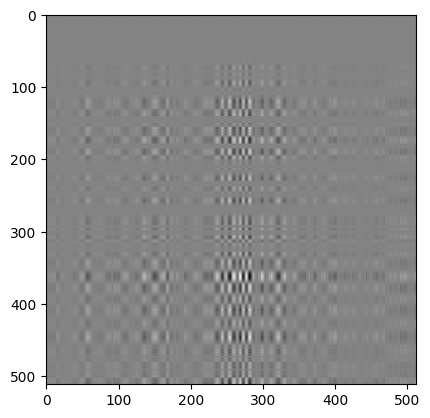

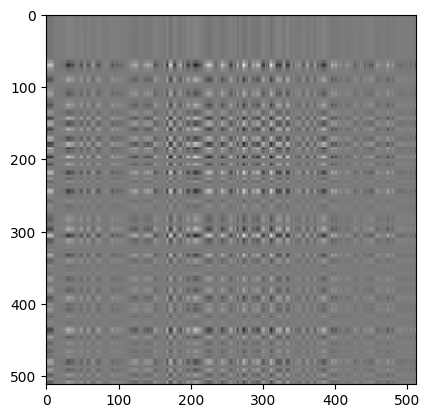

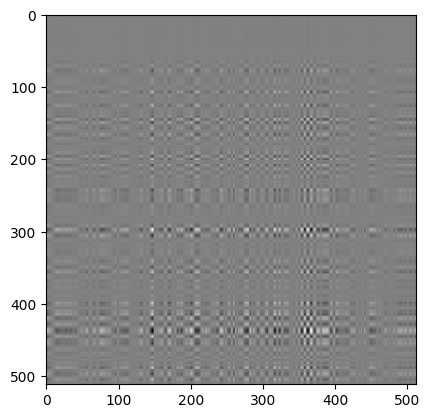

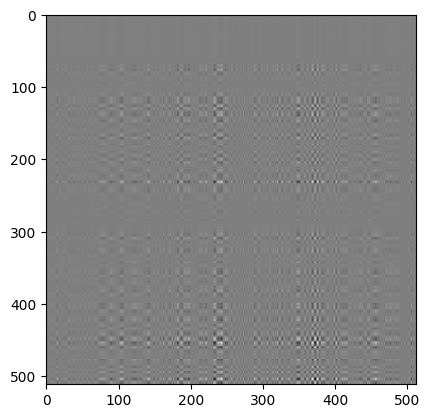

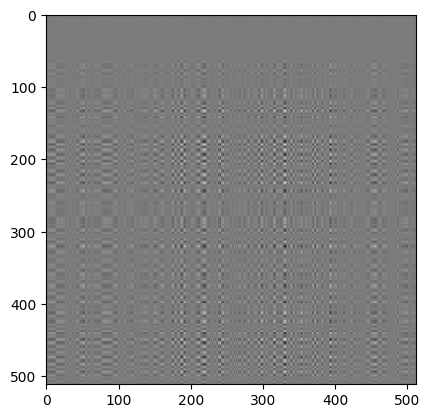

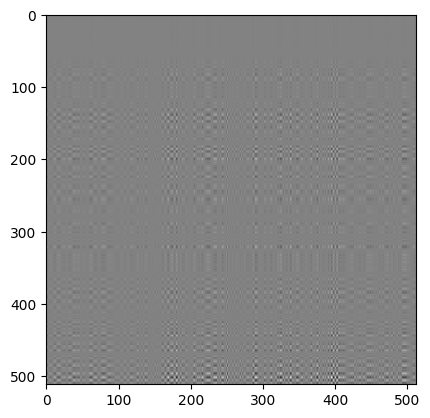

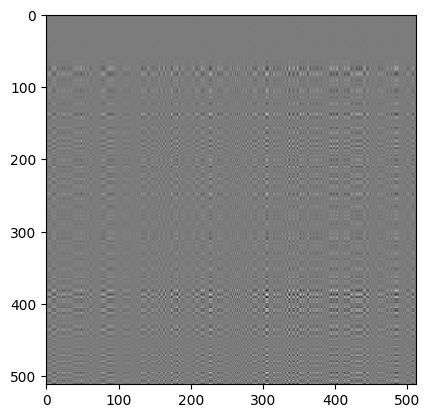

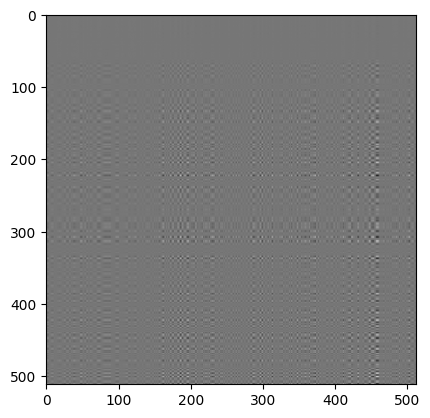

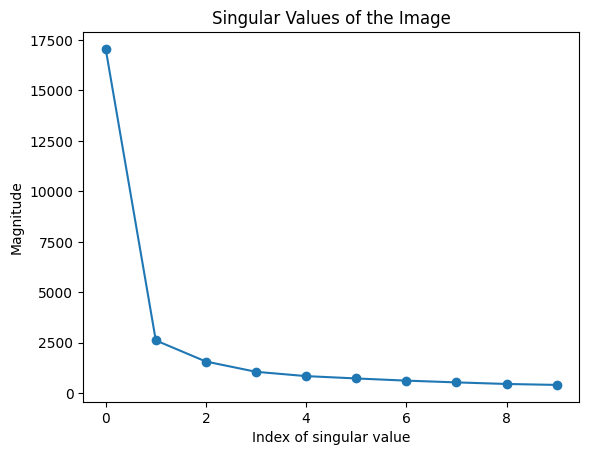

In [44]:
i_vals = np.arange(1, 100, 10)

all_singular_values = []
for i in i_vals:
    dyad = s[i] * np.outer(U[:, i], Vt[i, :])
    plt.imshow(dyad, cmap="gray")
    plt.show()
    all_singular_values.append(s[i])

plt.plot(all_singular_values, 'o-')
plt.title('Singular Values of the Image')
plt.xlabel('Index of singular value')
plt.ylabel('Magnitude')
plt.show()

### Notes on Dyads and Singular Values
1. I see that the higher (or starting) dyads have higher significance than the other (lower) dyads
2. The singular values are higher or greater at the start of the matrix and decrease rapidly. It also means the intensity for the higher corresponding dyads is more relevant.

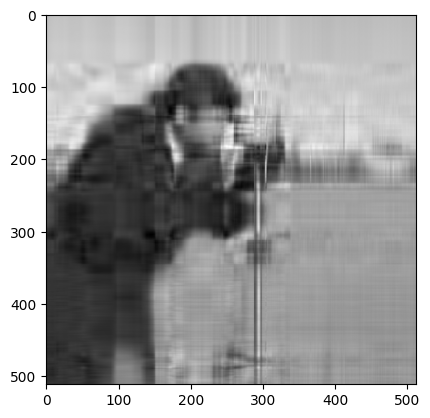

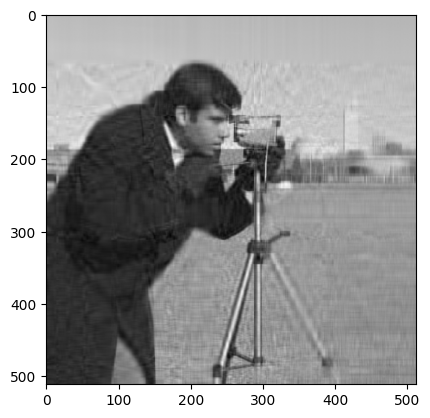

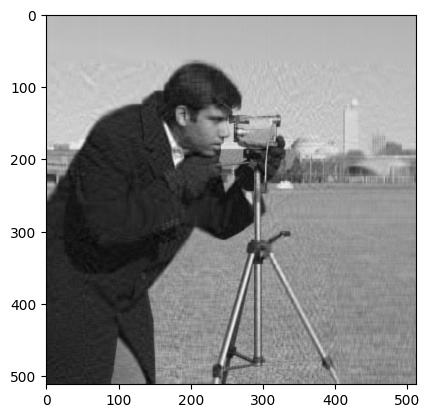

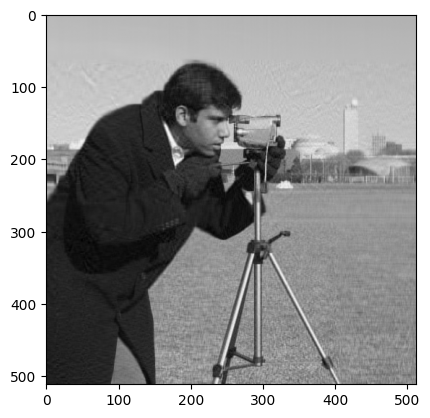

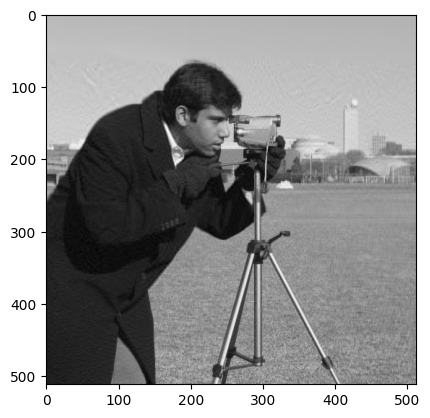

In [46]:
k_values = np.arange(10,100,20)
# print(len(k_values))

for k in k_values:
    Uk = U[:,:k] # m x k
    Sk = S[:k, :k] # k x k
    VTk = Vt[:k,:] # k x n

    # compute Xk
    Xk = Uk @ Sk @ VTk
    
    plt.imshow(Xk, cmap="gray")
    plt.show()

Reducing the number of dimension/bytes for the computation purposes has least impact of the quality. Even with k at a low of 70-80 we get good results.

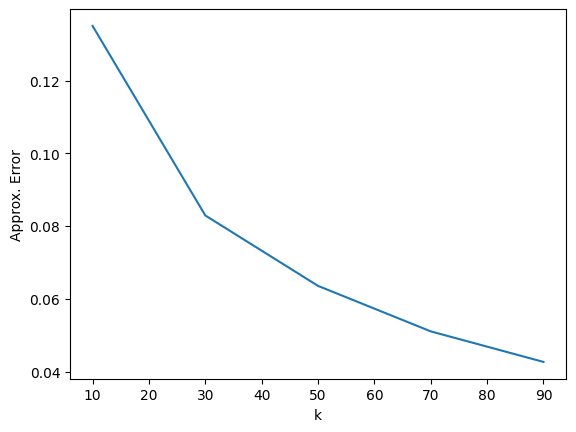

In [53]:
# Compute and plot approximation error for increasing value of k

X = U @ S @ Vt

i = 0
approx_erro_vals = []
for k in k_values:
    Uk = U[:,:k] # m x k
    Sk = S[:k, :k] # k x k
    VTk = Vt[:k,:] # k x n

    # compute Xk
    Xk = Uk @ Sk @ VTk
    
    # compute the norm and plot
    approx_erro_vals.append(np.linalg.norm(X - Xk, 'fro') / np.linalg.norm(X,'fro'))

plt.plot(k_values, approx_erro_vals)
plt.xlabel('k')
plt.ylabel('Approx. Error')
plt.show()

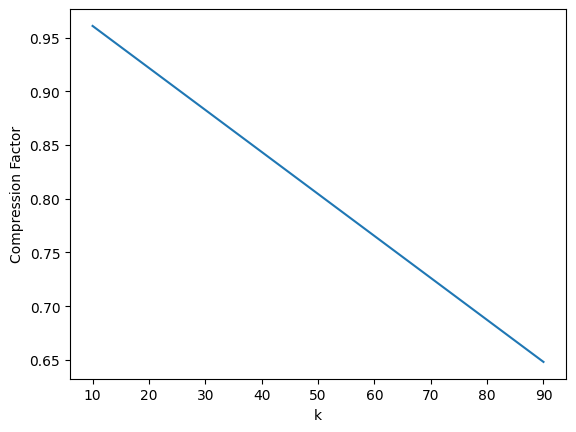

In [61]:
# Compute and plot the compression factor for increasing value of k

compression_values = []

i = 0
for k in k_values:
    Uk = U[:,:k] # m x k
    Sk = S[:k, :k] # k x k
    VTk = Vt[:k,:] # k x n

    # compute Xk
    Xk = Uk @ Sk @ VTk

    compression_values.append((1 - (k*(m+n+1)/(m*n))))

plt.plot(k_values, compression_values)
plt.xlabel('k')
plt.ylabel('Compression Factor')
plt.show()

In [67]:
# Compute the value k such that compression_k = 0

compression_k = 0
k = int((1 - compression_k) * (m*n)/(m+n+1))
print(f'When compression factor is 0 then k = {k}')

Uk = U[:,:k] # m x k
Sk = S[:k, :k] # k x k
VTk = Vt[:k,:] # k x n

# compute Xk
Xk = Uk @ Sk @ VTk
    
# compute the approximation error
k_approx_error = np.linalg.norm(X - Xk, 'fro') / np.linalg.norm(X,'fro')
print(f'then the approx. error = {k_approx_error}')


When compression factor is 0 then k = 255
then the approx. error = 0.010757614051817072


When compression factor is set to 0, we still get the k value as around half of the original and the approximate error is around 1% which mean that we only need half the number of pixel to approximate to the orignial image.

## Part 2: Classification of MNIST Digits with SVD Decomposition

In [68]:
import numpy as np
import pandas as pd

# Load data into memory
data = pd.read_csv('train.csv')

# Inspect the data
print(f"Shape of the data: {data.shape}")
print("")
print(data.head())

Shape of the data: (42000, 785)

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783

In [69]:
# Convert data into a matrix
data = np.array(data)

# Split data into a matrix X and a vector Y where:
#
# X is dimension (42000, 784)
# Y is dimension (42000, )
# Y is the first column of data, while X is the rest
X = data[:, 1:]
X = X.T
Y = data[:, 0]

print(X.shape, Y.shape)

d, N = X.shape

(784, 42000) (42000,)


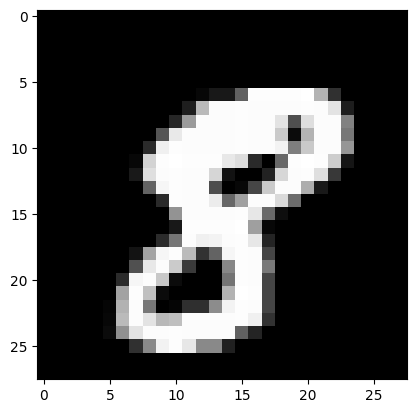

In [72]:
# Visualize different digits
def visualize(X, idx):
    # Visualize the image of index 'idx' from the dataset 'X'
    img = X[:, idx]
    
    # Reshape it
    img = np.reshape(img, (28, 28))

    # Visualize
    plt.imshow(img, cmap='gray')
    plt.show()

visualize(X, 10)

In [100]:
# Filter from X only those elements that corresponds to digits 3 or 4

filter_3or4 = (Y==3) | (Y==4)

XfilterDigits = X[:, filter_3or4]
YfilterDigits = Y[filter_3or4]
print(XfilterDigits.shape)
print(YfilterDigits.shape)

(784, 8423)
(8423,)


In [97]:
# Split the obtained dataset in training and testing

def split_data(X, Y):
    d, N = X.shape
    N_train = int(N * 0.8)
    print(f"Length of training set = {N_train}")

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    X_train = X[:, train_idx]
    Y_train = Y[train_idx]
    
    X_test = X[:, test_idx]
    Y_test = Y[test_idx]

    return (X_train, Y_train), (X_test, Y_test)

(X_train, Y_train), (X_test, Y_test) = split_data(XfilterDigits, YfilterDigits)

print(f"The shape of X_train = {X_train.shape}")

Length of training set = 6738
The shape of X_train = (784, 6738)


In [144]:
# Call X1 and X2 the submatrices of the training set
C1 = Y_train[Y_train==3]
C2 = Y_train[Y_train==4]

X1 = X_train[:, C1]
X2 = X_train[:, C2]

print(f'The shape of X1 = {X1.shape} and X2 = {X2.shape}')

The shape of X1 = (784, 3462) and X2 = (784, 3276)


In [106]:
# Compute SVD decomposition of X1 and X2

U1, s1, Vt1 = np.linalg.svd(X1, full_matrices=False)
U2, s2, Vt2 = np.linalg.svd(X2, full_matrices=False)

print(f'The shape of U1 = {U1.shape} and U2 = {U2.shape}')


The shape of U1 = (784, 784) and U2 = (784, 784)


In [152]:
# Take an unknown digit x from the test set and compute

dx, Nx = X_test.shape

randomNum = np.random.randint(1, Nx)

x = X_test[:,randomNum]
y = Y_test[randomNum]

x1t = U1 @ (U1.T @ x)
x2t = U2 @ (U2.T @ x)

print(f'The shape of x1t = {x1t.shape} and x2t = {x2t.shape}')


The shape of x1t = (784,) and x2t = (784,)


In [155]:
# Compute the distances
d1 = np.linalg.norm(x - x1t, 2) / np.linalg.norm(x,2)
d2 = np.linalg.norm(x - x2t, 2) / np.linalg.norm(x,2)


if (d1 < d2):
    print(f"Our algo 'thinks' it is 3 and when in fact it is {y == 3}")
else:
    print(f"Our algo 'thinks' it is 4  and when in fact it is {y == 4}")


Our algo 'thinks' it is 4  and when in fact it is True


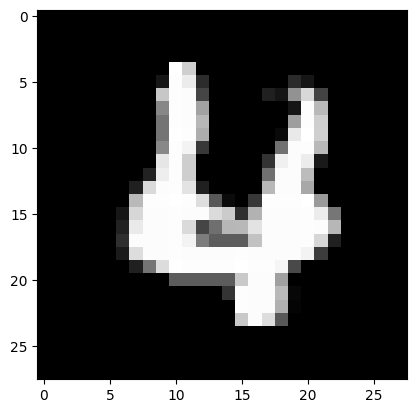

In [154]:
# Prove and visualize
xpic = np.reshape(x, (28, 28))
plt.imshow(xpic, cmap='gray')
plt.show()

In [180]:
# Repeat the expirement and compute the misclassification rate
testRandomValues = np.arange(1,Nx,20)
misclassification = 0

for test in testRandomValues:
    x = X_test[:,test]
    y = Y_test[test]

    x1t = U1 @ (U1.T @ x)
    x2t = U2 @ (U2.T @ x)

    d1 = np.linalg.norm(x - x1t, 2) / np.linalg.norm(x,2)
    d2 = np.linalg.norm(x - x2t, 2) / np.linalg.norm(x,2)
    
    if (d1 < d2):
        if (y == 4): misclassification += 1
    else:
        if (y == 3): misclassification += 1

print(f'Total misclassification rate = {misclassification / len(testRandomValues)}')

85
Total misclassification rate = 0.15294117647058825


In [223]:
# Repeat the experiment for different digits for 7 or 9
number1 = 1
number2 = 5

filter_7or9 = (Y==number1) | (Y==number2)

XfilterDigits2 = X[:, filter_7or9]
YfilterDigits2 = Y[filter_7or9]

(X_train1, Y_train1), (X_test1, Y_test1) = split_data(XfilterDigits2, YfilterDigits2)

dx1, Nx1 = X_test1.shape
print(f'Length of testing set = {X_test1.shape}')

# Call X1 and X2 the submatrices of the training set
C12 = Y_train1[Y_train1==number1]
C22 = Y_train1[Y_train1==number2]

X12 = X_train1[:, C12]
X22 = X_train1[:, C22]

U12, s12, Vt12 = np.linalg.svd(X12, full_matrices=False)
U22, s22, Vt22 = np.linalg.svd(X22, full_matrices=False)

testRandomValues1 = np.arange(1,Nx1,5)
misclassification1 = 0

for test in testRandomValues1:
    x = X_test1[:,test]
    y = Y_test1[test]

    x1t = U12 @ (U12.T @ x)
    x2t = U22 @ (U22.T @ x)

    d1 = np.linalg.norm(x - x1t, 2) / np.linalg.norm(x,2)
    d2 = np.linalg.norm(x - x2t, 2) / np.linalg.norm(x,2)
    
    if (d1 < d2):
        if (y == number2): misclassification1 += 1
    else:
        if (y == number1): misclassification1 += 1

print(f'Total misclassification rate = {misclassification1 / len(testRandomValues1)}')

Length of training set = 6783
Length of testing set = (784, 1696)
Total misclassification rate = 0.4365781710914454


Here are some misclassification rates:
1. 7 and 9 = 0.511
2. 6 and 8 = 0.472
3. 1 and 7 = 0.530
4. 4 and 5 = 0.511
5. 6 and 9 = 0.444
6. 8 and 9 = 0.506
7. 5 and 8 = 0.536
8. 1 and 8 = 0.462
9. 1 and 6 = 0.405
10. 1 and 5 = 0.436
Misclassification rises rapidly when it involves the similar looking digits like 1 or 7, 9 or 7.

In [234]:
# Repeat the exercise above with a 3-digit example
number1 = 6
number2 = 9
number3 = 7

filter_7or9 = (Y==number1) | (Y==number2) | (Y==number3)

XfilterDigits2 = X[:, filter_7or9]
YfilterDigits2 = Y[filter_7or9]

(X_train1, Y_train1), (X_test1, Y_test1) = split_data(XfilterDigits2, YfilterDigits2)

dx1, Nx1 = X_test1.shape
print(f'Length of testing set = {X_test1.shape}')

# Call X1 and X2 the submatrices of the training set
C12 = Y_train1[Y_train1==number1]
C22 = Y_train1[Y_train1==number2]
C32 = Y_train1[Y_train1==number3]


X12 = X_train1[:, C12]
X22 = X_train1[:, C22]
X32 = X_train1[:, C32]


U12, s12, Vt12 = np.linalg.svd(X12, full_matrices=False)
U22, s22, Vt22 = np.linalg.svd(X22, full_matrices=False)
U32, s32, Vt32 = np.linalg.svd(X32, full_matrices=False)


testRandomValues1 = np.arange(1,Nx1,5)
misclassification1 = 0

for test in testRandomValues1:
    x = X_test1[:,test]
    y = Y_test1[test]

    x1t = U12 @ (U12.T @ x)
    x2t = U22 @ (U22.T @ x)
    x3t = U32 @ (U32.T @ x)

    d1 = np.linalg.norm(x - x1t, 2) / np.linalg.norm(x,2)
    d2 = np.linalg.norm(x - x2t, 2) / np.linalg.norm(x,2)
    d3 = np.linalg.norm(x - x3t, 2) / np.linalg.norm(x,2)

    
    if (d1 < d2 and d1 < d3):
        if (y == number2 or y == number3): 
            misclassification1 += 1
    elif (d2 < d1 and d2 < d3):
        if (y == number1 or y == number3): 
            misclassification1 += 1
    else:
        if (y == number2 | y == number3): 
            misclassification1 += 1

print(f'Total misclassification rate = {misclassification1 / len(testRandomValues1)}')

Length of training set = 10180
Length of testing set = (784, 2546)
Total misclassification rate = 0.6404715127701375


We have following errors for following combinations of values:
1. 1 / 5 / 9 = 0.329
2. 1 / 7 / 9 = 0.273
3. 5 / 4 / 8 = 0.681
4. 6 / 9 / 7 = 0.640

It suggests that now the misclassification error has intensified